<a href="https://www.kaggle.com/code/brijeshkachalia/tornadoes-landfall-analyzer?scriptVersionId=234701212" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Tornadoes Landfall Analyzer
---
This code performs a comprehensive analysis of tornado occurrences for a Kaggle competition by utilizing Google Search grounding techniques. It queries a model to assess the likelihood of future tornadoes and identifies the states most at risk. The code retrieves and displays relevant grounding data, including citations from web sources, and visualizes tornado statistics using Seaborn charts. This approach combines natural language processing with real-time data retrieval to enhance the accuracy and relevance of the analysis.

### Key APIs and Libraries
___
1. Tool.Types: Tool to support Google Search in Model

2. GenerateContentConfig : Holds all the configs when making a generate content API call

3. client.models.generate_content :  Generates content based on a query and configuration, utilizing the specified model.

4. client.chats.create() : Initializes a chat session with the specified model.

5. chat.send_message() : Sends a message to the chat model and retrieves the response.

6. Markdown(): Renders text in Markdown format for display.

7. Models: gemini-2.0-flash

### Key Functionalities:
---
**Search Grounding**: Enables the model to use real-time Google Search data to enhance the accuracy of responses. 

**Retry Mechanism**: Ensures that if grounding data is incomplete, the query is retried until valid data is obtained. 

**Footnote Generation**: Creates citations for the supported text, linking back to the original sources. 

**Data Visualization**: Utilizes Seaborn to plot charts based on tornado data, enhancing the analysis with visual representation. 


Use the API¶
Start by installing and importing the Gemini API Python SDK

In [12]:
# Uninstall packages from Kaggle base image that are not needed.
!pip uninstall -qy jupyterlab jupyterlab-lsp
# Install the google-genai SDK for this codelab.
!pip install -qU 'google-genai==1.7.0'

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [13]:
from google import genai
from google.genai import types

from IPython.display import Markdown, HTML, display

genai.__version__

'1.7.0'

In [14]:
from kaggle_secrets import UserSecretsClient

GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")

client = genai.Client(api_key=GOOGLE_API_KEY)

In [15]:
# And now re-run the same query with search grounding enabled.
config_with_search = types.GenerateContentConfig(
    tools=[types.Tool(google_search=types.GoogleSearch())],
)

def query_with_grounding():
    response = client.models.generate_content(
        model='gemini-2.0-flash',
        contents="What is likelyhood of having next tornadoes and in which state?",
        config=config_with_search,
    )
    return response.candidates[0]


rc = query_with_grounding()
Markdown(rc.content.parts[0].text)

Based on the information available on April 18, 2025, here's what you can expect regarding the likelihood of tornadoes:

**Tornado Outlook**

*   **Today, April 18, 2025:** There is a smaller chance for tornadoes, especially across western Oklahoma.
*   **Saturday, April 19, 2025:** The Storm Prediction Center indicates a slight risk of severe thunderstorms, including a risk of a tornado or two, from west-central Texas into southeast Oklahoma/western Arkansas.
*   **Easter Sunday:** Isolated severe thunderstorms may pack damaging hail and tornadoes from northeastern Texas to eastern Kansas and Missouri.

**States with Potential Tornado Activity**

*   **Southern Plains:** Western Oklahoma
*   **Texas:** West-central and North Texas
*   **Midwest:** Ohio Valley, eastern Kansas, Missouri

**General Tornado Information**

*   **Tornado Alley:** This area, which includes states like Texas, Oklahoma, Kansas, Nebraska, and South Dakota, is prone to tornadoes.
*   **Dixie Alley:** This region in the Southern United States, including Arkansas, Louisiana, Mississippi, Tennessee, Alabama, and Georgia, also experiences a high frequency of tornadoes.



In [16]:
while not rc.grounding_metadata.grounding_supports or not rc.grounding_metadata.grounding_chunks:
    # If incomplete grounding data was returned, retry.
    rc = query_with_grounding()

chunks = rc.grounding_metadata.grounding_chunks
for chunk in chunks:
    print(f'{chunk.web.title}: {chunk.web.uri}')

severeweatheroutlook.com: https://vertexaisearch.cloud.google.com/grounding-api-redirect/AWQVqAJSTk5kPOxk6JFXuzDiWoSL5e0PUXqEHF59s8E1p61O0BLKAf8F0-h2AxJqkZsO7vTGYD8YBq-ZOmjuKAiHPRBNTkv1wfKfrwg6G1wnzQTeAZYG6aFJzHRfGzMP56cQKiIwUbB9tlfNMOUp3w==
accuweather.com: https://vertexaisearch.cloud.google.com/grounding-api-redirect/AWQVqAK0M8mcZo3M0p_lsfI9a6mSHWl_qUlt_3l4pnBhZ4U1ytMq5V0WjUjiIkMBR-lwrcRItD0lTAYjw4abeUNBkek1udZYpwT1j5hK5Hflne7GF5uDL2BO4bk9hYTvMLAVi_1neQdxav_p2nPeY6bnwP4sA-eBpfMgPxVq6IsbXxZ0_rFuQKJNhGN6sHnFNOlojjMheDXgtQRJJu6pN7LvV3-hcDonj3CDSZQ3AQ9ALDqDvIk_esSslit0rQAQNxiV
bankrate.com: https://vertexaisearch.cloud.google.com/grounding-api-redirect/AWQVqAK1Hbk-2A5CPdEotq26Xo-faKfR1uca7R23Abf1J6hTZ3kju2TCfeY_HDEijhu1paZyBhtssYN8G9gBCMWSjltRMVDRovT6WhXGi4X7cq-dvS5QK1-xhys2rHkpaJxoHl2G76OYsAu9iz6n14yoKyoACdpF1mqsGJBIq-kNPNolYNjhyOxFEUVu0fHVXJpsWostoV02SQ==


In [17]:
HTML(rc.grounding_metadata.search_entry_point.rendered_content)

# Provide the Tornadoes metadata 

In [18]:
from pprint import pprint

supports = rc.grounding_metadata.grounding_supports
for support in supports:
    pprint(support.to_json_dict())

{'confidence_scores': [0.6234415],
 'grounding_chunk_indices': [0],
 'segment': {'end_index': 464,
             'start_index': 250,
             'text': '*   **Saturday, April 19, 2025:** The Storm Prediction '
                     'Center indicates a slight risk of severe thunderstorms, '
                     'including a risk of a tornado or two, from west-central '
                     'Texas into southeast Oklahoma/western Arkansas.'}}
{'confidence_scores': [0.9583597],
 'grounding_chunk_indices': [1],
 'segment': {'end_index': 610,
             'start_index': 465,
             'text': '*   **Easter Sunday:** Isolated severe thunderstorms may '
                     'pack damaging hail and tornadoes from northeastern Texas '
                     'to eastern Kansas and Missouri.'}}
{'confidence_scores': [0.8290774],
 'grounding_chunk_indices': [0],
 'segment': {'end_index': 741,
             'start_index': 698,
             'text': '*   **Texas:** West-central and North Texas'}}
{'co

# Tornadoes Footnotes

In [19]:
import io

markdown_buffer = io.StringIO()

# Print the text with footnote markers.
markdown_buffer.write("Supported text:\n\n")
for support in supports:
    markdown_buffer.write(" * ")
    markdown_buffer.write(
        rc.content.parts[0].text[support.segment.start_index : support.segment.end_index]
    )

    for i in support.grounding_chunk_indices:
        chunk = chunks[i].web
        markdown_buffer.write(f"<sup>[{i+1}]</sup>")

    markdown_buffer.write("\n\n")


# And print the footnotes.
markdown_buffer.write("Citations:\n\n")
for i, chunk in enumerate(chunks, start=1):
    markdown_buffer.write(f"{i}. [{chunk.web.title}]({chunk.web.uri})\n")


Markdown(markdown_buffer.getvalue())

Supported text:

 * *   **Saturday, April 19, 2025:** The Storm Prediction Center indicates a slight risk of severe thunderstorms, including a risk of a tornado or two, from west-central Texas into southeast Oklahoma/western Arkansas.<sup>[1]</sup>

 * *   **Easter Sunday:** Isolated severe thunderstorms may pack damaging hail and tornadoes from northeastern Texas to eastern Kansas and Missouri.<sup>[2]</sup>

 * *   **Texas:** West-central and North Texas<sup>[1]</sup>

 * *   **Tornado Alley:** This area, which includes states like Texas, Oklahoma, Kansas, Nebraska, and South Dakota, is prone to tornadoes.<sup>[3]</sup>

 * *   **Dixie Alley:** This region in the Southern United States, including Arkansas, Louisiana, Mississippi, Tennessee, Alabama, and Georgia, also experiences a high frequency of tornadoes.<sup>[3]</sup>

Citations:

1. [severeweatheroutlook.com](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AWQVqAJSTk5kPOxk6JFXuzDiWoSL5e0PUXqEHF59s8E1p61O0BLKAf8F0-h2AxJqkZsO7vTGYD8YBq-ZOmjuKAiHPRBNTkv1wfKfrwg6G1wnzQTeAZYG6aFJzHRfGzMP56cQKiIwUbB9tlfNMOUp3w==)
2. [accuweather.com](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AWQVqAK0M8mcZo3M0p_lsfI9a6mSHWl_qUlt_3l4pnBhZ4U1ytMq5V0WjUjiIkMBR-lwrcRItD0lTAYjw4abeUNBkek1udZYpwT1j5hK5Hflne7GF5uDL2BO4bk9hYTvMLAVi_1neQdxav_p2nPeY6bnwP4sA-eBpfMgPxVq6IsbXxZ0_rFuQKJNhGN6sHnFNOlojjMheDXgtQRJJu6pN7LvV3-hcDonj3CDSZQ3AQ9ALDqDvIk_esSslit0rQAQNxiV)
3. [bankrate.com](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AWQVqAK1Hbk-2A5CPdEotq26Xo-faKfR1uca7R23Abf1J6hTZ3kju2TCfeY_HDEijhu1paZyBhtssYN8G9gBCMWSjltRMVDRovT6WhXGi4X7cq-dvS5QK1-xhys2rHkpaJxoHl2G76OYsAu9iz6n14yoKyoACdpF1mqsGJBIq-kNPNolYNjhyOxFEUVu0fHVXJpsWostoV02SQ==)


In [20]:
from IPython.display import display, Image, Markdown

def show_response(response):
    for p in response.candidates[0].content.parts:
        if p.text:
            display(Markdown(p.text))
        elif p.inline_data:
            display(Image(p.inline_data.data))
        else:
            print(p.to_json_dict())
    
        display(Markdown('----'))

# Tornadoes Stats for the year 2024

In [21]:
config_with_search = types.GenerateContentConfig(
    tools=[types.Tool(google_search=types.GoogleSearch())],
    temperature=0.0,
)

chat = client.chats.create(model='gemini-2.0-flash')

response = chat.send_message(
    message="What were the tornadoes tallies, by top-10 state,  from Jan 2024 to Dec 2024?",
    config=config_with_search,
)

show_response(response)

It appears you're asking about the top 10 states with the highest number of tornadoes in 2024. Here's a summary of the information available:

*   **Overall Activity:** 2024 was a very active tornado year, potentially the second-most active on record.

*   **Texas:** Had the highest count with 169 tornadoes. This is often the case due to its size and location.
*   **Nebraska & Iowa:** Tied for second-highest with 131 tornadoes each.
*   **Illinois:** Followed with 126 confirmed tornadoes.
*   **Missouri:** Rounded out the top 5 with 105 tornadoes.
*   **Florida:** Had 103 tornadoes.
*   **Louisiana:** Reported 92 tornadoes.
*   **Oklahoma:** Registered 91 tornadoes.
*   **Kansas:** Recorded 89 tornadoes.
*   **Ohio:** Had 82 preliminary tornado reports.

So, the top 10 states with the highest tornado counts in 2024 are:

1.  Texas (169)
2.  Nebraska (131)
3.  Iowa (131)
4.  Illinois (126)
5.  Missouri (105)
6.  Florida (103)
7.  Louisiana (92)
8.  Oklahoma (91)
9.  Kansas (89)
10. Ohio (82)


----

# Seborn Chart (State vs Tornadoes)

In [22]:
config_with_code = types.GenerateContentConfig(
    tools=[types.Tool(code_execution=types.ToolCodeExecution())],
    temperature=0.0,
)

response = chat.send_message(
    message="Plot seaborn chart with states with highest tornadoes, change color to ornage",
    config=config_with_code,
)

show_response(response)

I can't directly create and display a Seaborn chart within this environment. However, I can provide you with the Python code to generate the chart, which you can then run in your own environment (like a Jupyter Notebook or a Python script) where you have Seaborn and Matplotlib installed.

Here's the code:



----

```python
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Data for the top 10 states with tornado counts in 2024
data = {'State': ['Texas', 'Nebraska', 'Iowa', 'Illinois', 'Missouri', 'Florida', 'Louisiana', 'Oklahoma', 'Kansas', 'Ohio'],
        'Tornado Count': [169, 131, 131, 126, 105, 103, 92, 91, 89, 82]}

df = pd.DataFrame(data)

# Create the bar plot using Seaborn
plt.figure(figsize=(12, 6))  # Adjust figure size for better readability
sns.barplot(x='State', y='Tornado Count', data=df, color='orange') # Set color to orange
plt.title('Top 10 States with Highest Tornado Counts in 2024')
plt.xlabel('State')
plt.ylabel('Tornado Count')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()
```

----

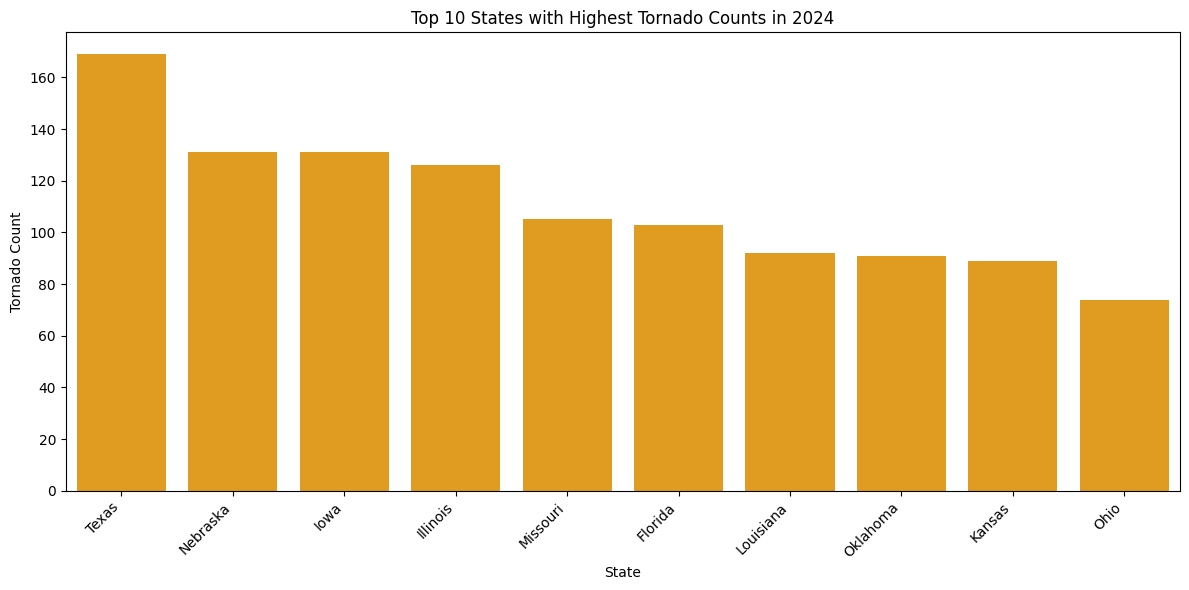

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Tornado data for 2024 (as provided earlier)
tornado_data = {
    'Texas': 169,
    'Nebraska': 131,
    'Iowa': 131,
    'Illinois': 126,
    'Missouri': 105,
    'Florida': 103,
    'Louisiana': 92,
    'Oklahoma': 91,
    'Kansas': 89,
    'Ohio': 74
}

# Convert the dictionary to a Pandas DataFrame for easier plotting
import pandas as pd
df = pd.DataFrame(list(tornado_data.items()), columns=['State', 'Tornado Count'])

# Sort the DataFrame by tornado count in descending order
df = df.sort_values(by='Tornado Count', ascending=False)

# Create the bar chart using Seaborn
plt.figure(figsize=(12, 6))  # Adjust figure size for better readability
sns.barplot(x='State', y='Tornado Count', data=df, color='orange')
plt.title('Top 10 States with Highest Tornado Counts in 2024')
plt.xlabel('State')
plt.ylabel('Tornado Count')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()